# Introdução

Atividade 1 realizada para a materia de Redes neurais ministrada pelo Prof. Dr. Lucas Correia Ribas.

Este notebook inclui a implementação pedida de um perceptron, funções para seu treinamento, e visualização/análise de seus resultados.

![perceptron_sketch](img/recap.png)

# Metodologia

## Inicialização dos datasets

In [1]:
import pandas as pd

df_train_loaded = pd.read_csv("datasets/train_dataset1.csv")
df_test_loaded = pd.read_csv("datasets/test_dataset1.csv")
X_train = df_train_loaded.drop("label", axis=1).values.T # (n_features, n_amostras)
y_train = df_train_loaded["label"].values.reshape(1, -1) # (1, n_amostras)
X_test = df_test_loaded.drop("label", axis=1).values.T
y_test = df_test_loaded["label"].values.reshape(1, -1)

#print(df_train_loaded)

## Implementação do perceptron


<Figure size 600x400 with 0 Axes>

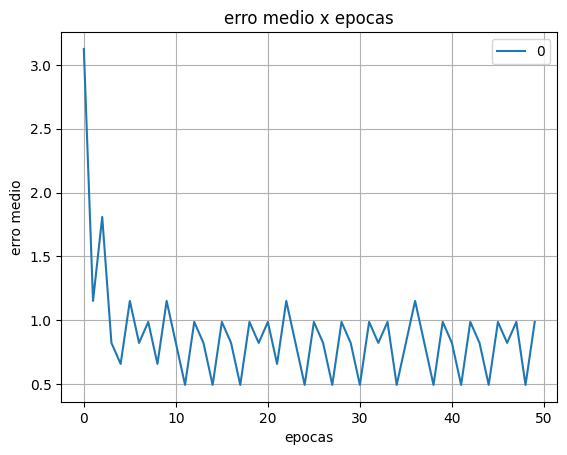

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_weights(n_features, seed=None):
    rg = np.random.default_rng(seed)
    weights = rg.random((1, n_features))[0]

    return weights

def weighted_sum(features, weights, bias):
    return np.dot(features, weights) + bias 

def activate(w_sum):
    return 1 if w_sum > 0 else 0

def sigmoid_activation(w_sum):
    return 1/(1+np.exp(-w_sum))

def error(target, pred):
    # --- problem encountered here ---
    # original code:
    # return -(target*np.log10(pred) + (1-target)*np.log10(1-pred))
    # if pred is close to zero or 1, log10 starts nearing negative infinity
    # solution was to clip input between values VERY close to 0 or VERY close to 1

    pred = np.clip(pred, 1e-10, (1 - 1e-10))
    return -(target*np.log(pred) + (1-target)*np.log(1-pred))
    
def update_weights(weights, learn_rate, target, pred, features):
    new_weights = []

    for x,w in zip(features, weights):
        new_w = w + learn_rate*(target - pred)*x
        new_weights.append(new_w)

    return new_weights

def update_bias(bias, l_rate, target, pred):
    return bias + l_rate*(target - pred)

def train_network(data, weights, bias, learn_rate, epochs):

    for e in range(epochs): # passo 5
        losses = []
        predicted_values = []

        for i in range(len(data)):
            #features = data.iloc[i, :-1] 
            features = np.append(data.iloc[i, :-1].values, 1)
            target = data.iloc[i, -1] # passo 2

            w_sum = weighted_sum(features, weights, bias)
            pred = activate(w_sum)
            predicted_values.append(pred)
            loss = error(target, pred)
            losses.append(loss)

            if pred != target:
                weights = update_weights(weights, learn_rate, target, pred, features) # passo 6
                bias = update_bias(bias, learn_rate, target, pred)

        avg_loss = sum(losses)/len(losses)
        epoch_loss.append(avg_loss)
        #print(f"----\n EPOCH {e+1}\n AVERAGE LOSS = {avg_loss}\n")

    return weights, predicted_values

# -- running model --
df = df_train_loaded # passo 1
df["label"] = df["label"].replace({-1: 0}) 
weights = generate_weights((df.shape[1]), 42) # passo 3

#print(df)
#print("\n\n", weights)

bias = -1
learn_rate = 0.1 # passo 4
epochs = 50

epoch_loss = []
new_weights, predicted_values = train_network(df, weights, bias, learn_rate, epochs)

# -- plots --
plt.figure(figsize=(6, 4))
pd.DataFrame(epoch_loss).plot(kind="line", grid=True)
plt.title("erro medio x epocas")
plt.xlabel("epocas")
plt.ylabel("erro medio")
plt.show()


## Funções para avaliação do modelo

Para a realização da análise do modelo desenvolvido, foi implementado uma função que apenas realiza a classificação dos dados do dataset utilizando os pesos já calculados na fase de treinamento. Isso permite avaliar a performance do modelo treinado. Complementando essa implementação, foram também feitas funções para calcular a acurácia da classificação dos dados e plotar um gráfico demonstrando como a linha de decisão resultante do treinamento dos modelos passa pelos dados de cada dataset.  

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# function that uses the calculated new_weights from the training phase to classify a dataset 
def only_classify(data, weights, bias, learn_rate, epochs):

    predicted_values = []
    for i in range(len(data)):
        features = np.append(data.iloc[i, :-1].values, 1)
        target = data.iloc[i, -1]  # passo 2
        w_sum = weighted_sum(features, weights, bias)
        pred = sigmoid_activation(w_sum)
        predicted_values.append(pred)
    # epoch_loss.append(avg_loss)
    # print(f"----\n EPOCH {e+1}\n AVERAGE LOSS = {avg_loss}\n")

    return predicted_values

def calculate_accuracy(predicted_values, target):
    if len(predicted_values) != len(target):
        raise ValueError("pred and target have different lengths")

    # converting decimal predicted value into binary values (like target) 
    predicted_binary = [1 if p >= 0.5 else 0 for p in predicted_values]

    hits = sum(p == t for p, t in zip(predicted_binary, target))
    accuracy = hits / len(target)

    return accuracy

def plot_decision_boundary(data, weights, bias, accuracy, title):
    x1 = data.iloc[:, 0]
    x2 = data.iloc[:, 1]
    y = data.iloc[:, -1]

    plt.scatter(x1[y == 0], x2[y == 0], color='blue', label='y=0')
    plt.scatter(x1[y == 1], x2[y == 1], color='red', label='y=1')

    x1_vals = np.linspace(min(x1) - 0.5, max(x1) + 0.5, 100)
    x2_vals = -(weights[0] * x1_vals + bias) / weights[1]

    plt.plot(x1_vals, x2_vals, 'k--', label="fronteira de decisão")

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    
    plt.figtext(
        0.51, -0.09,
        f"acuracia={accuracy}",
        fontsize="small",
        ha="center",
        va="bottom"
    )
    
    plt.show()

def plot_epoch_loss(epoch_loss, learn_rate, epochs, accuracy):
    plt.figure(figsize=(6, 4))
    ax = pd.DataFrame(epoch_loss).plot(kind="line", grid=True)
    ax.set_title("dataset de treinamento")
    ax.set_xlabel("epocas")
    ax.set_ylabel("erro medio")
    plt.figtext(0.51, -0.09,
                f"taxa de aprendizado={learn_rate},\nepocas={epochs}\nacuracia={accuracy}",
                fontsize="small", 
                ha="center",
                va="bottom")
    plt.show()

# Resultados

## Dataset 1

<Figure size 600x400 with 0 Axes>

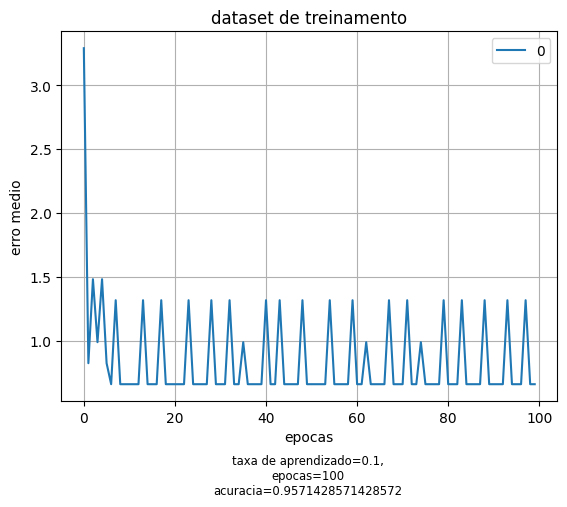

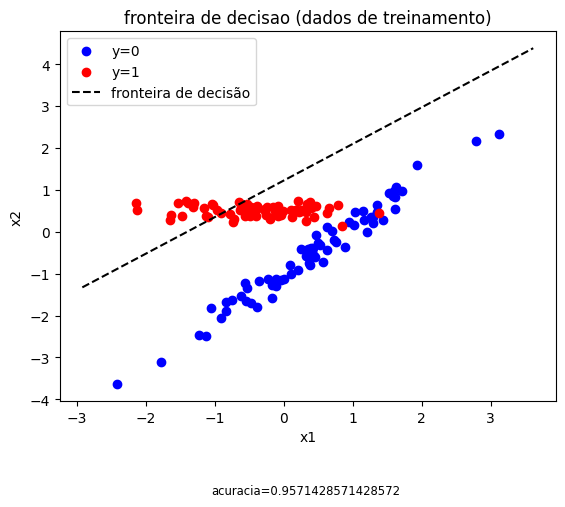

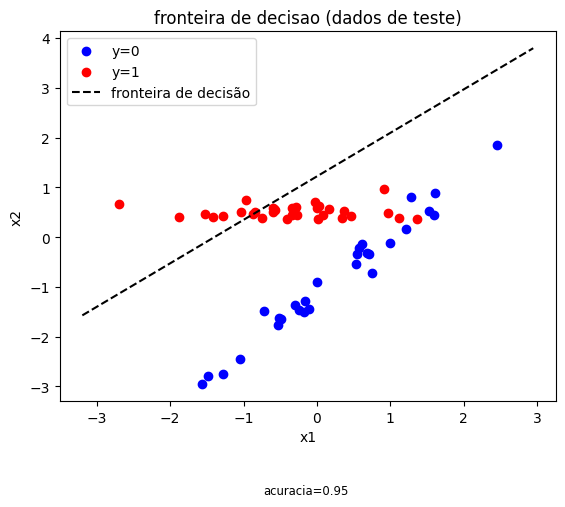

In [16]:
import pandas as pd

# teste usando dataset 1
df_train_loaded = pd.read_csv("datasets/train_dataset1.csv")
df_test_loaded = pd.read_csv("datasets/test_dataset1.csv")

# treinamento e coleta de pesos 
bias = -1
learn_rate = 0.1
epochs = 100

df_train = df_train_loaded
df_train["label"] = df_train["label"].replace({-1: 0}) 
weights = generate_weights((df_train.shape[1]))

epoch_loss = []
new_weights, train_pred = train_network(df_train, weights, bias, learn_rate, epochs)

# teste nos dados de treinamento 
predicted_values = only_classify(df_train, new_weights, bias, learn_rate, epochs)
accuracy = calculate_accuracy(predicted_values, df_train["label"])

plot_epoch_loss(epoch_loss, learn_rate, epochs, accuracy)
plot_decision_boundary(df_train, new_weights, bias, accuracy, "fronteira de decisao (dados de treinamento)")

# teste com dataset de teste 
df_test = df_test_loaded 
df_test["label"] = df_test["label"].replace({-1: 0}) 

predicted_values = only_classify(df_test, new_weights, bias, learn_rate, epochs)
accuracy = calculate_accuracy(predicted_values, df_test["label"])

plot_decision_boundary(df_test, new_weights, bias, accuracy, "fronteira de decisao (dados de teste)")


### Resultados

O modelo conseguiu alcançar uma acurácia relativamente alta após seu treinamento, tendo uma queda de performance perceptível mas aceitável quando é aplicado ao modelo de teste. O erro médio durante as épocas entra em um plateau em torno da época 60, mostrando uma boa generalização dos dados treinados.  


## Dataset 2

<Figure size 600x400 with 0 Axes>

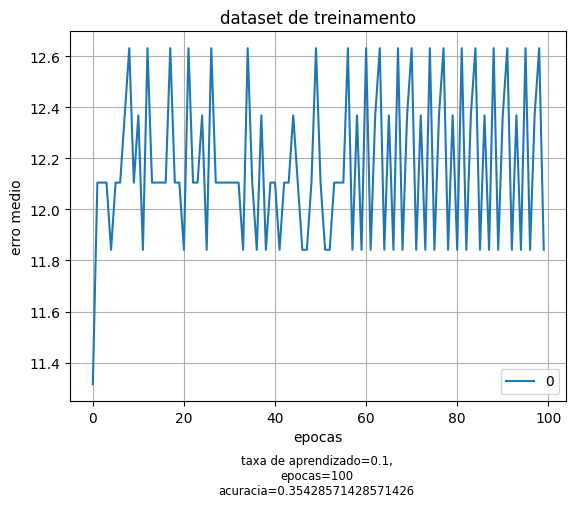

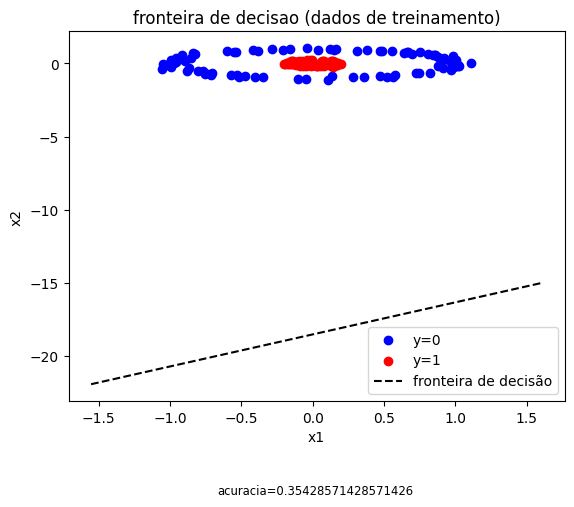

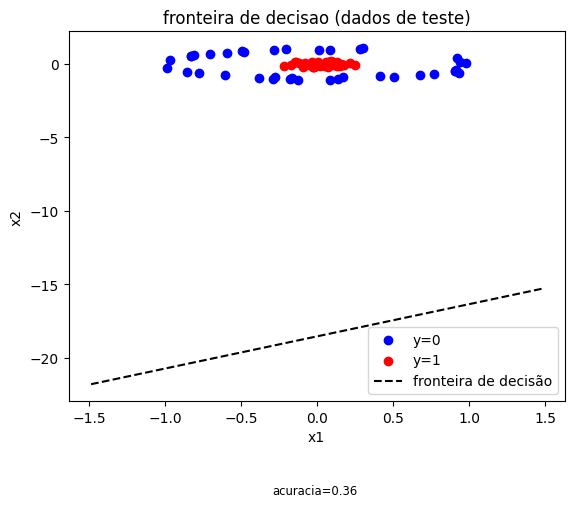

In [113]:
import pandas as pd 

df_train_loaded = pd.read_csv("datasets/train_dataset2.csv")
df_test_loaded = pd.read_csv("datasets/test_dataset2.csv")

# treinamento e coleta de pesos 
bias = -1
learn_rate = 0.1
epochs = 100

df_train = df_train_loaded
df_train["label"] = df_train["label"].replace({-1: 0}) 
weights = generate_weights((df_train.shape[1])) 

epoch_loss = []
new_weights, train_pred = train_network(df_train, weights, bias, learn_rate, epochs)

# teste nos dados de treinamento
predicted_values = only_classify(df_train, new_weights, bias, learn_rate, epochs)
accuracy = calculate_accuracy(predicted_values, df_train["label"])

plot_epoch_loss(epoch_loss, learn_rate, epochs, accuracy)
plot_decision_boundary(df_train, new_weights, bias, accuracy, "fronteira de decisao (dados de treinamento)")

# teste com dataset de teste 
df_test = df_test_loaded 
df_test["label"] = df_test["label"].replace({-1: 0}) 

predicted_values = only_classify(df_test, new_weights, bias, learn_rate, epochs)
accuracy = calculate_accuracy(predicted_values, df_test["label"])

plot_decision_boundary(df_test, new_weights, bias, accuracy, "fronteira de decisao (dados de teste)")


### Resultados

O dados do dataset 2 são característicos de um conjunto de dados não linearmente separável. Subsequentemente, o modelo composto de um único perceptron não é capaz de realizar uma classificação correta dos dados. Isto é aparente quando se observa o gráfico de erro médio por épocas, onde a taxa de erro oscila entre taxas de erro medio altas, visto que o modelo não consegue encontrar pesos que corretamente separem as classes do dataset. O modelo subsequentemente traça uma fronteira de decisão completamente errônea.   


## Dataset 3

<Figure size 600x400 with 0 Axes>

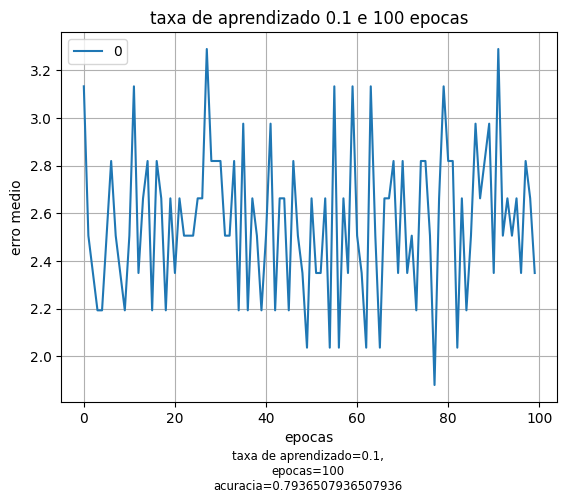

<Figure size 600x400 with 0 Axes>

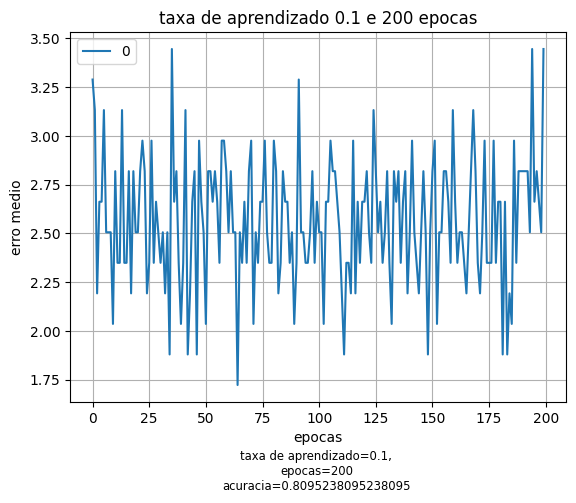

<Figure size 600x400 with 0 Axes>

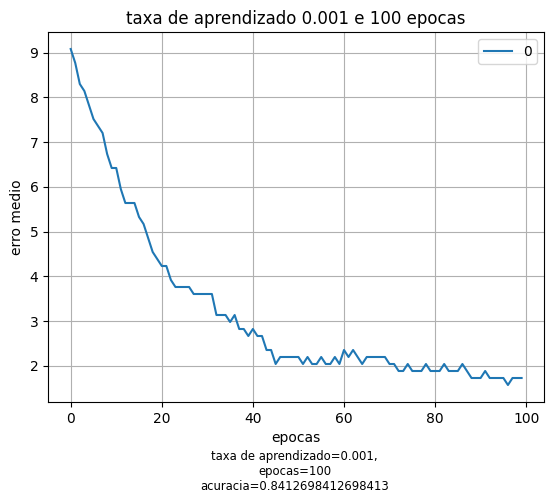

<Figure size 600x400 with 0 Axes>

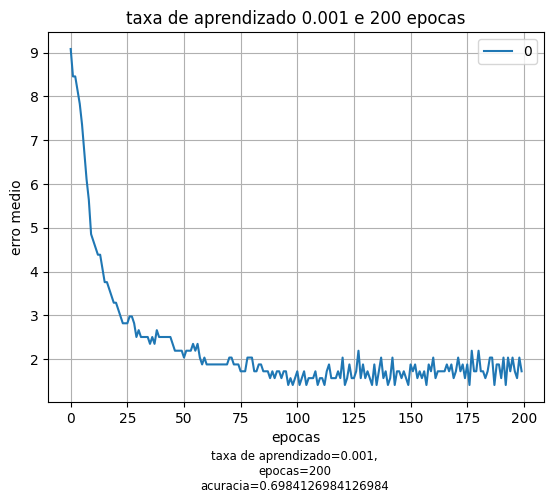

<Figure size 600x400 with 0 Axes>

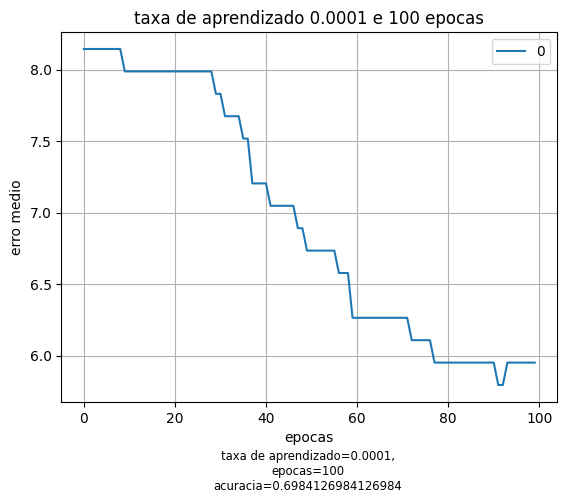

<Figure size 600x400 with 0 Axes>

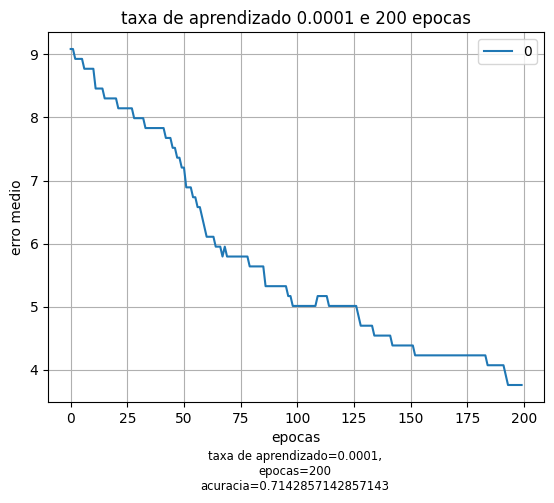

In [20]:
import pandas as pd

learn_rates = [0.1, 0.001, 0.0001]
epochs_list = [100, 200]

df_train_loaded = pd.read_csv("datasets/train_dataset3.csv")
df_test_loaded = pd.read_csv("datasets/test_dataset3.csv")

for learn_rate in learn_rates:
    for epochs in epochs_list:
        
        bias = -1
        df_train = df_train_loaded.copy()
        df_train["label"] = df_train["label"].replace({-1: 0}) 
        weights = generate_weights((df_train.shape[1]))
        epoch_loss = []
        new_weights, train_pred = train_network(df_train, weights, bias, learn_rate, epochs)
        
        # teste com dataset de treinamento 
        df_test = df_test_loaded.copy()
        df_test["label"] = df_test["label"].replace({-1: 0}) 
        predicted_values = only_classify(df_test, new_weights, bias, learn_rate, epochs)
        accuracy_test = calculate_accuracy(predicted_values, df_test["label"])
        #plot_decision_boundary(df_test, new_weights, bias, "fronteira de decisao (dados de teste)")
        
        plt.figure(figsize=(6, 4))
        ax = pd.DataFrame(epoch_loss).plot(kind="line", grid=True)
        ax.set_title(f"taxa de aprendizado {learn_rate} e {epochs} epocas")
        ax.set_xlabel("epocas")
        ax.set_ylabel("erro medio")
        plt.figtext(0.51, -0.08,
                    f"taxa de aprendizado={learn_rate},\nepocas={epochs}\nacuracia={accuracy_test}",
                    fontsize="small", 
                    ha="center",
                    va="bottom")
        plt.show()
        

### Resultados 

O dataset 3 possui uma alta dimensionalidade. Tais features subsequentemente aparentam viabilizar uma classificação razoável dos dados pelo modelo. Uma alta taxa de aprendizado (0.1) parece previnir que a taxa de erro diminua suavemente e entre em um plateau, produzindo uma acurácia menor do que os resultados com taxas de aprendizado menores, independente do número de épocas. 
Para os resultados com taxas de aprendizado menores, um maior número de épocas permite o modelo alcançar um plateau aceitável dos dados com mais certeza.   